### Прогноз числа посещений в неделю

Прочитаем данные. Преобразуем их во временной ряд, для которого будет строить прогноз. Временной ряд будет включать в себя две колонки: дату и число посещений в неделю.

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime as dt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
dt.datetime.strptime('2015-02-01', '%Y-%m-%d')

datetime.datetime(2015, 2, 1, 0, 0)

In [248]:
data = pd.read_csv('hackathon_data_encrypted.csv', parse_dates=[2], date_parser=dateparse, sep=';')
data.dtypes
data.head()

,ID,CLINIC_ID,SUNDAY_DATE,RECEIPTS,CHRONICS,PATIENTS,VISITS,DISTRICT
0,0,22,2015-02-01,1375.97983,2561.180290,52306.839700,1490.849731,1
1,1,22,2015-02-08,1375.97983,2561.180290,52306.839700,1713.030031,1
2,2,22,2015-02-15,1375.97983,2561.180290,52306.839700,1725.217136,1
3,3,22,2015-02-22,1375.97983,2561.180290,52306.839700,1637.094992,1
4,4,22,2015-03-01,1383.63984,2569.560144,48436.923188,1430.851675,1


Сделаем прогноз отдельно для каждой клиники. Так как мы работаем с временными рядами, возможно существуют эффекты, связанные с сезонностью. Для наблюдения этих эффектов, визуализируем данные для нескольких клиник. Построим графики зависимости числа посетителей в неделю от времени.

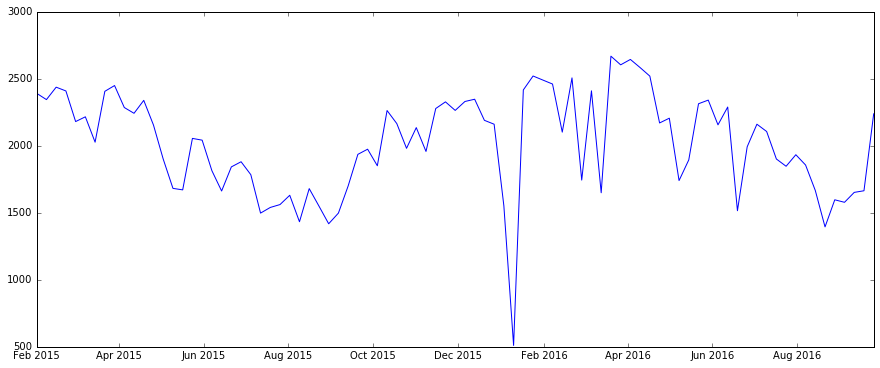

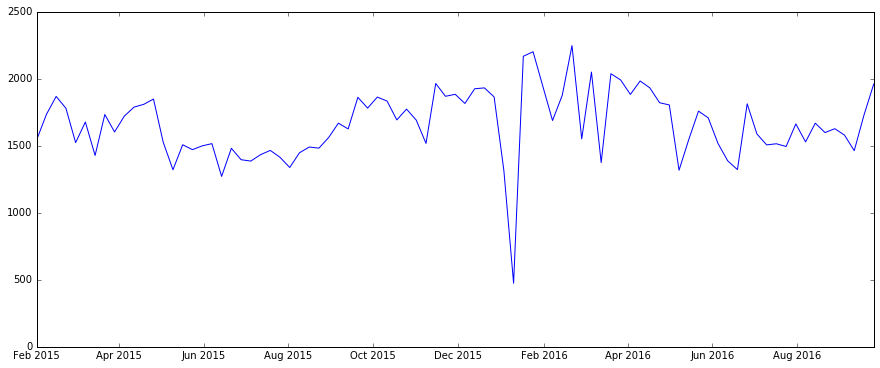

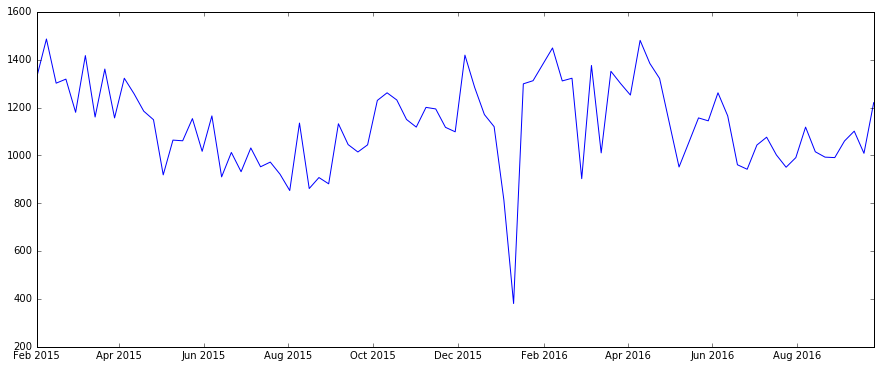

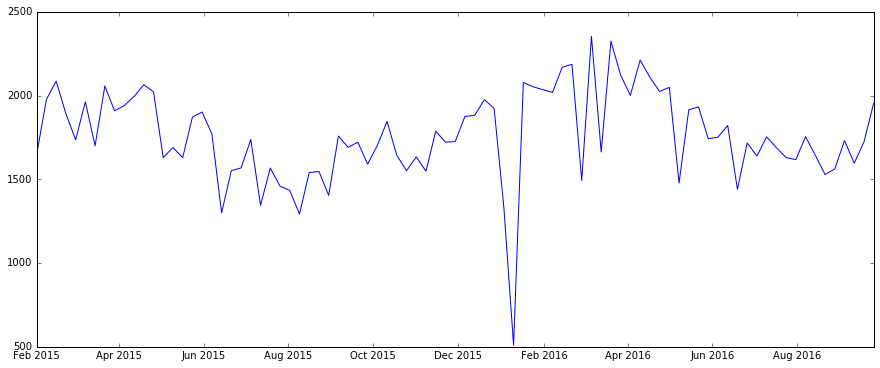

In [249]:
clinic_1 = data[data['CLINIC_ID']==1]
clinic_8 = data[data['CLINIC_ID']==8]
clinic_16 = data[data['CLINIC_ID']==16]
clinic_20 = data[data['CLINIC_ID']==20]


plt.plot(clinic_1['SUNDAY_DATE'], clinic_1['VISITS'])
plt.show()
plt.plot(clinic_8['SUNDAY_DATE'], clinic_8['VISITS'])
plt.show()
plt.plot(clinic_16['SUNDAY_DATE'], clinic_16['VISITS'])
plt.show()
plt.plot(clinic_20['SUNDAY_DATE'], clinic_20['VISITS'])
plt.show()

На представленных графиках можно наблюдать ярко выраженную сезонность: посещаемость клиник резко падает в последнюю неделю декабря и первую неделю января (Новый год), а также в районе 23 февраля, 8 марта и майских праздников. Пик посещений приходится на весенние месяцы (март-апрель), минимум - на лето. В целом, люди чаще болеют в холодные месяцы, чем в теплые. 

Определим стационарность временного ряда, построив скользящее среднее и скользящее стандартное отклонение. При этом исключим аномальные даты (праздники) из рассмотрения.

In [253]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


Исключим из статистики аномальные даты (праздники).

In [254]:
clinic_1 = data[(data['CLINIC_ID']==1)&(data['SUNDAY_DATE']!='2016-01-03')&(data['SUNDAY_DATE']!='2016-01-10')
                &(data['SUNDAY_DATE']!='2016-02-28')&(data['SUNDAY_DATE']!='2016-03-13')&(data['SUNDAY_DATE']!='2016-05-08')]
clinic_8 = data[(data['CLINIC_ID']==8)&(data['SUNDAY_DATE']!='2016-01-03')&(data['SUNDAY_DATE']!='2016-01-10')
                &(data['SUNDAY_DATE']!='2016-02-28')&(data['SUNDAY_DATE']!='2016-03-13')&(data['SUNDAY_DATE']!='2016-05-08')]
clinic_16 = data[(data['CLINIC_ID']==16)&(data['SUNDAY_DATE']!='2016-01-03')&(data['SUNDAY_DATE']!='2016-01-10')
                &(data['SUNDAY_DATE']!='2016-02-28')&(data['SUNDAY_DATE']!='2016-03-13')&(data['SUNDAY_DATE']!='2016-05-08')]
clinic_20 = data[(data['CLINIC_ID']==20)&(data['SUNDAY_DATE']!='2016-01-03')&(data['SUNDAY_DATE']!='2016-01-10')
                &(data['SUNDAY_DATE']!='2016-02-28')&(data['SUNDAY_DATE']!='2016-03-13')&(data['SUNDAY_DATE']!='2016-05-08')]
clinic_1 = clinic_1[["VISITS", 'SUNDAY_DATE']].set_index('SUNDAY_DATE')
clinic_8 = clinic_8[["VISITS", 'SUNDAY_DATE']].set_index('SUNDAY_DATE')
clinic_16 = clinic_16[["VISITS", 'SUNDAY_DATE']].set_index('SUNDAY_DATE')
clinic_20 = clinic_20[["VISITS", 'SUNDAY_DATE']].set_index('SUNDAY_DATE')

C:\Users\asedov001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=12).mean()
C:\Users\asedov001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=12).std()


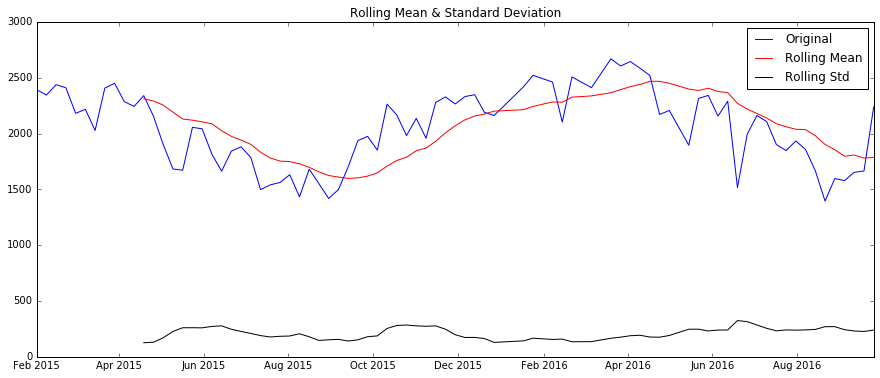

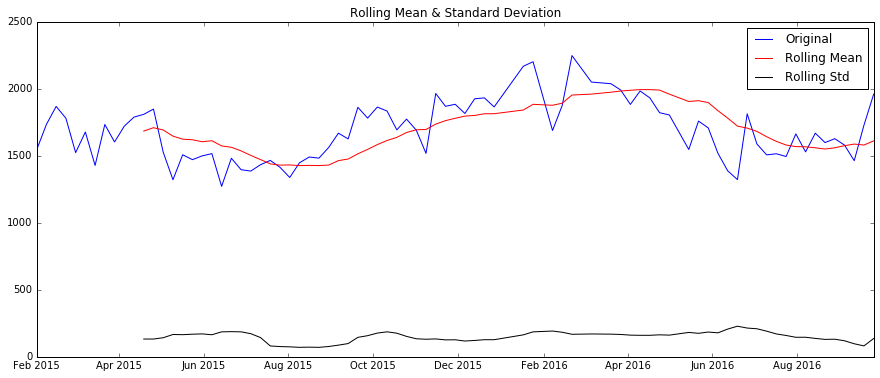

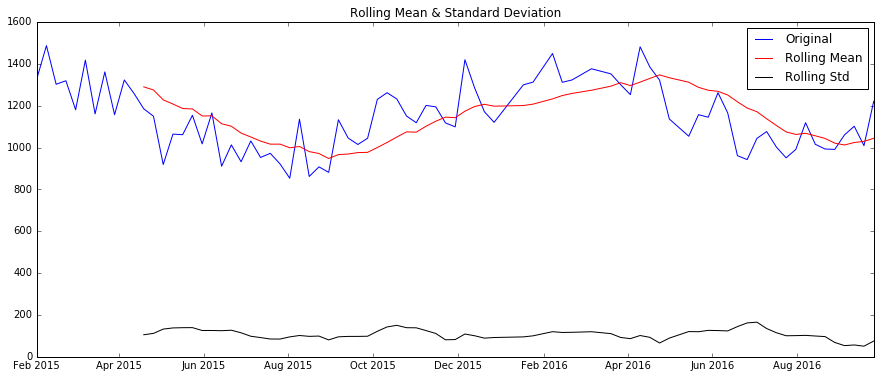

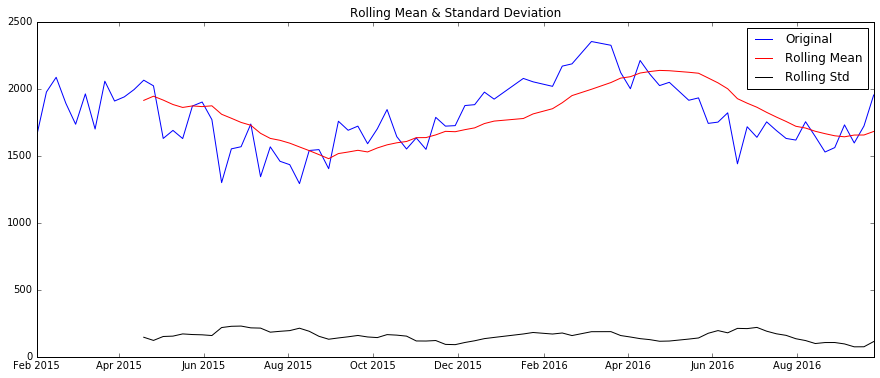

In [255]:
test_stationarity(clinic_1)
test_stationarity(clinic_8)
test_stationarity(clinic_16)
test_stationarity(clinic_20)

Хоть скользяцее стандартное отклонение изменяется мало, скользящее среднее следует эффекту сезонности, а значит временной ряд нестационарен. Для построения прогнозной модели временной ряд должен быть стационарным, поэтому попытаемся избавиться от сезонности. Для этого возьмем логарифм числа посетителей и вычтем сдвиг.

C:\Users\asedov001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=12).mean()
C:\Users\asedov001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=12).std()


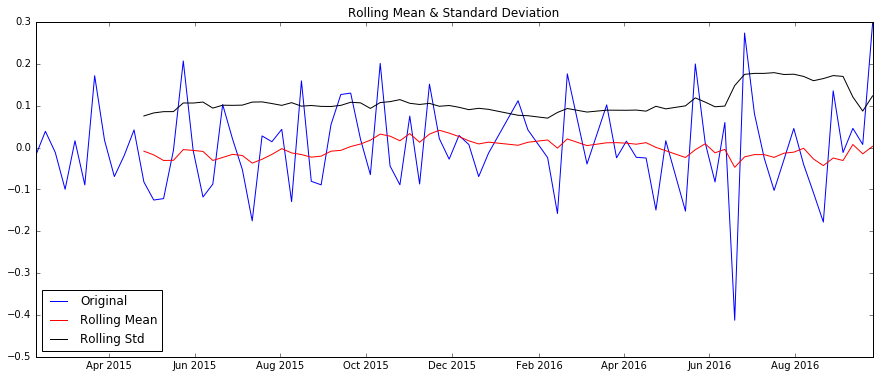

In [256]:
def diff(ts):
    ts_log = np.log(ts)
    ts_log_diff = ts_log - ts_log.shift()
    ts_log_diff.dropna(inplace=True)
    test_stationarity(ts_log_diff)

diff(clinic_1)


Функция возвращает стационарный временной ряд: кользящее среднее и скользящее стандартное отклонение изменяется мало. Для прогноза используем Autoregressive Integrated Moving Average - ARIMA, которая является доработанной версией простой ARMA-модели для временных рядов.

In [257]:
from statsmodels.tsa.arima_model import ARIMA

def arima(ts):
    ts_log = np.log(ts)
    ts_log_diff = ts_log - ts_log.shift()
    ts_log_diff.dropna(inplace=True)
    model = ARIMA(ts_log_diff, order=(2, 1, 0))  
    results_ARIMA = model.fit(disp=-1)  
    plt.plot(ts_log_diff)
    plt.plot(results_ARIMA.fittedvalues, color='red')

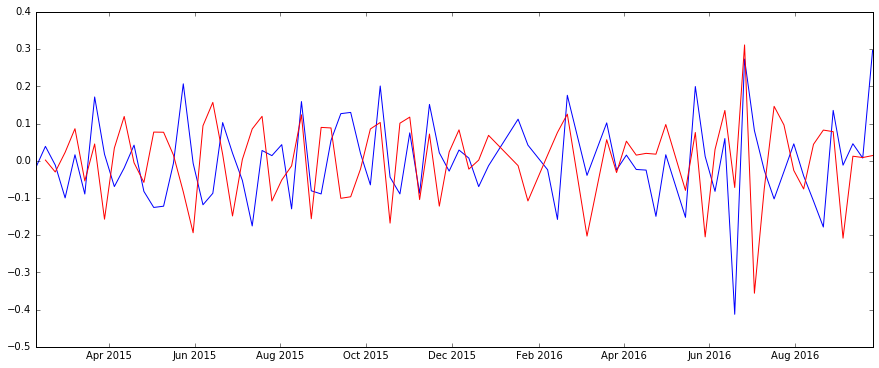

In [258]:
arima(clinic_1)

Получив предсказание, выполним обратное преобразование временного ряда, вернув сезонность.

In [259]:
def arima_back(ts):
    ts_log = np.log(ts)
    ts_log_diff = ts_log - ts_log.shift()
    shift = ts_log.shift()
    ts_log_diff.dropna(inplace=True)
    model = ARIMA(ts_log_diff, order=(2, 1, 0))  
    results_ARIMA = model.fit(disp=-1)
    
    predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
    predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
    predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
    predictions_ARIMA = np.exp(predictions_ARIMA_log + shift['VISITS'])
    plt.plot(ts)
    plt.plot(predictions_ARIMA)
    plt.show()


Итоговое предсказание для клиник 1, 8, 16 и 20.

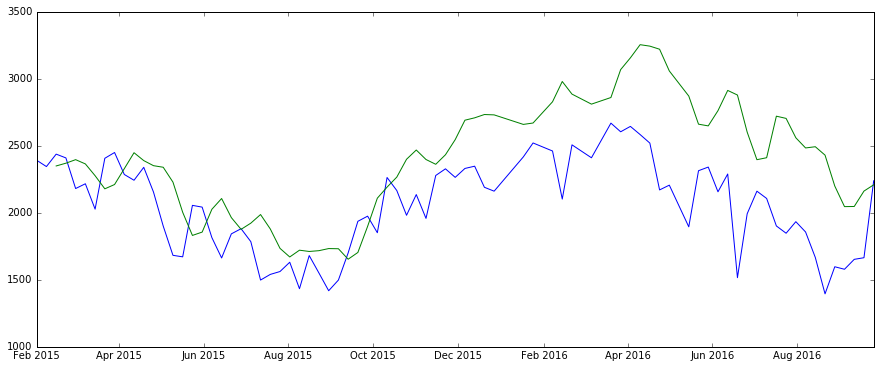

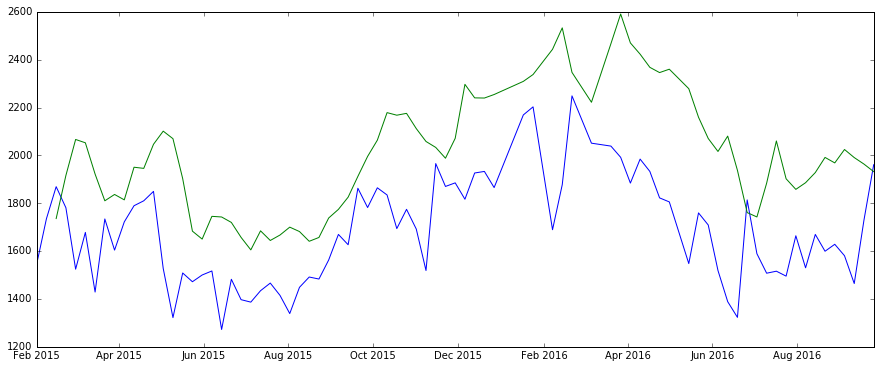

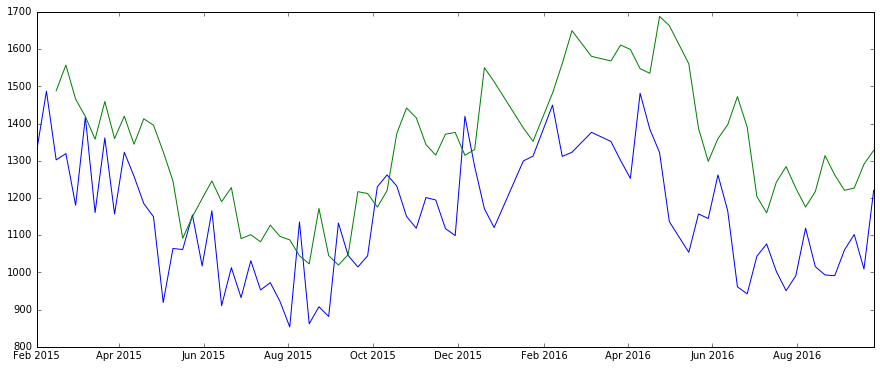

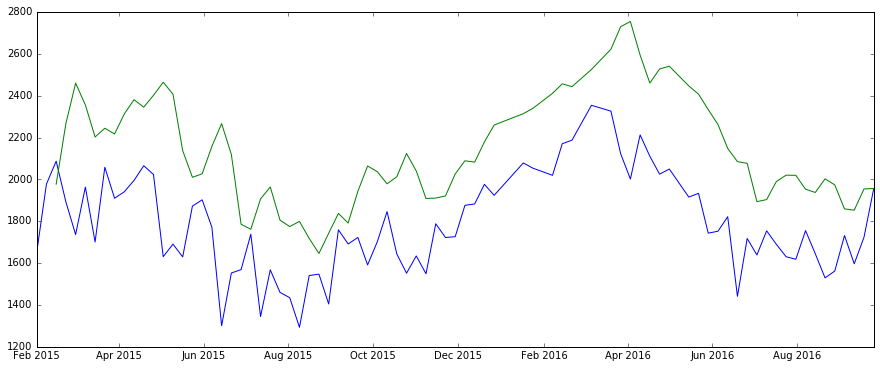

In [260]:
arima_back(clinic_1)
arima_back(clinic_8)
arima_back(clinic_16)
arima_back(clinic_20)

